### IMPORTING LIBRARIES

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

from matplotlib import colors

import numpy as np

from ipywidgets import widgets
from IPython.display import display, HTML

import collections
import operator

import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date


from utils.data_access_api import DataAccessApi
import dc_au_colormaps
import utils.dc_mosaic_RC ## RC customized
#import utils.dc_mosaic   ## the previous one
import datacube
#dc = DataAccessApi()
dc = datacube.Datacube()
api = datacube.api.API(datacube=dc)

from utils.dc_notebook_utilitiesLF import *
import utils.dc_utilities as utilities

#import datacube
from utils.dc_utilities import perform_timeseries_analysis
#from utils.dc_utilities_EH import perform_timeseries_analysis
from utils.dc_chunker import create_geographic_chunks, combine_geographic_chunks


# To keep screen as clean as possble
import warnings
warnings.filterwarnings("ignore")

### PARAMETERS AND USEFUL FUNCTIONS

In [22]:
# Define the time window
year_splitting = [[1999,2000,2001,2002],[2003,2004,2005,2006,2007],[2008,2009,2010,2011,2012],[2013,2014,2015,2016,2017]]

start = str(year_splitting[0][0])+'-1-1'
end = str(year_splitting[-1][-1])+'-12-31'
start_date_init = datetime.strptime(start, '%Y-%m-%d')
end_date_init = datetime.strptime(end, '%Y-%m-%d')


plat ="LANDSAT_7"
prod = "ls7_ledaps_swiss"
#plat = "LANDSAT_5"
#prod = "ls5_ledaps_swiss"

## considered months
sel_months = [5,6,7,8,9]

## mask categories (2=cloud shadow, 3=snow, 4=cloud , 255=fill)
no_cats=[2,3,4,255]

## thresholds
ndvi_threshold=0.8
ts_percentage=0.45

## resolution (is it correct?)
resolution_km2=25*25/1000000

# dictionary for plotting later in the scatter plot
surface_dict={}
indicator_dict={}

In [23]:
def tupple_to_cond(cats):
    for m in range(1,len(cats)+1):
        if m == 1: cond_cats = '(dataset_in.cf_mask == %i)' % (cats[m-1])
        else: cond_cats = '%s | (dataset_in.cf_mask == %i)' % (cond_cats, cats[m-1])
    return cond_cats

### CANTON GVA 

In [24]:
# Canton GVA
min_lon = 5.93771 
max_lon = 6.31743
min_lat = 46.12089
max_lat = 46.37531

In [25]:
## Canton GVA MASK
from osgeo import gdal
dataset = gdal.Open("GE_MASK_corr.tif")

print("Number of layers ".format(dataset.RasterCount))
print("==== Some info ====")
print("Size of tif file is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
mask_GE = np.array(dataset.GetRasterBand(1).ReadAsArray())
print("The shape of the array is {} ".format(mask_GE.shape))

Number of layers 
==== Some info ====
Size of tif file is 1400 x 938 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
The shape of the array is (938, 1400) 


### MINI DATA CUBE 

In [26]:
tmp_dc = DataAccessApi()
acquisitions_list_init=tmp_dc.list_acquisition_dates(product=prod, platform=plat, 
        latitude=(min_lat, max_lat), longitude=(min_lon,max_lon),  
        time=(start_date_init,end_date_init))  

[1999, 2000, 2001, 2002]
The forest coverage is  36.6075 km2, for a total of 58572 / 447334 forest pixels
The total surface  279.58375 km2
[2003, 2004, 2005, 2006, 2007]
The forest coverage is  30.055 km2, for a total of 48088 / 447334 forest pixels
The total surface  279.58375 km2
[2008, 2009, 2010, 2011, 2012]
The forest coverage is  31.57625 km2, for a total of 50522 / 447334 forest pixels
The total surface  279.58375 km2
[2013, 2014, 2015, 2016, 2017]
The forest coverage is  32.158125 km2, for a total of 51453 / 447334 forest pixels
The total surface  279.58375 km2


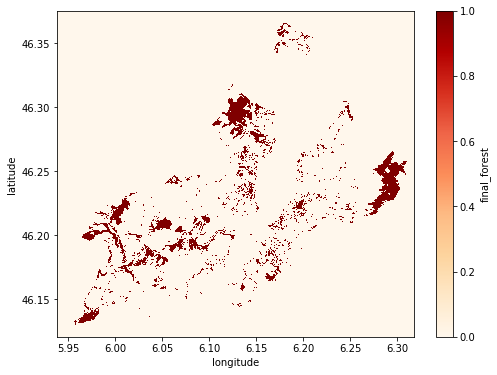

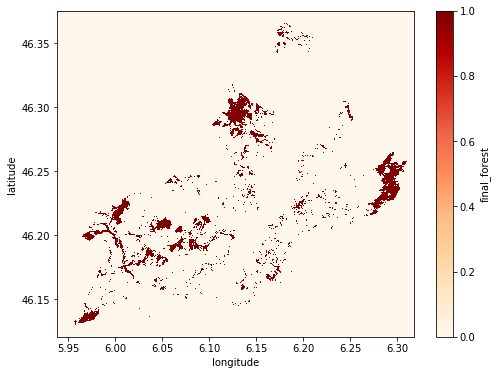

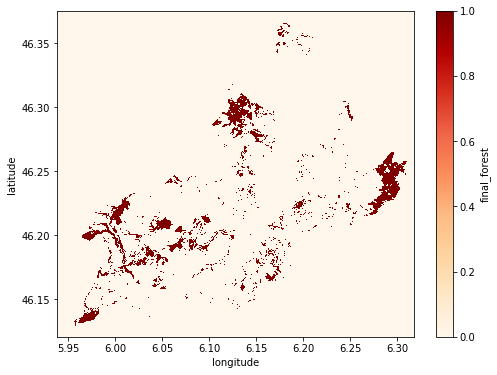

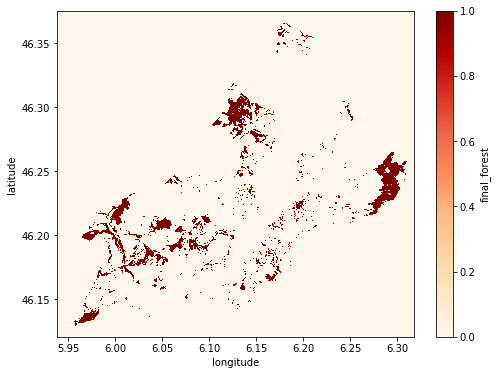

In [27]:
## The LOOP

for row in year_splitting:   
    print(row)
    acquisitions_list_year = []
    for y in row:
        #print(y)
        for t in acquisitions_list_init:
            if (t.year==y): 
                acquisitions_list_year.append(t)
    #print("Acquisition list ",acquisitions_list_year)
    #print("====================")
    dataset_in = dc.load(platform=plat,
                     product=prod,
                     time=(acquisitions_list_year[0],acquisitions_list_year[-1]),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     measurements=['red', 'nir','cf_mask'])
    with np.errstate(invalid='ignore'):
        ndvi = (dataset_in.nir - dataset_in.red) / (dataset_in.nir + dataset_in.red)
    dataset_in['ndvi'] = ndvi.astype(float)

    with np.errstate(invalid='ignore'):
        select_ndvi = dataset_in.ndvi> ndvi_threshold
    dataset_in['forest_mask'] = select_ndvi.astype(int) 
    
    ## filtering for the months and the mask
    dataset_in = dataset_in.sel(time=np.isin(dataset_in['time.month'], sel_months))
    dataset_in = dataset_in.where(mask_GE==1)
    
    unfiltered_forest=dataset_in.forest_mask

    # create dataset for forests (ndvi>xx)
    unfiltered_forest_dataset = unfiltered_forest.astype(np.int16).to_dataset(name = "forest")

    if len(no_cats) > 0:
        no_data = eval(tupple_to_cond(no_cats))
        no_data = no_data.values ## create a mask for the pixels where we don't have clear sky (cf_mask = 2,3,4,255)
        # Apply no_data on MDC
        unfiltered_forest_dataset.forest.values[no_data] = 255 ## N.B. this sets all the values of forest where we 
        # have no data to 255. It is needed for the perform_timeseries_analysis step

    ts = perform_timeseries_analysis(unfiltered_forest_dataset,"forest", no_data = 255)
    
    # select normalized threshold
    with np.errstate(invalid='ignore'):
        forest = ts.normalized_data>ts_percentage
    dataset_in['final_forest'] = forest.astype(int)
    #print(dataset_in.final_forest)
    dataset_in.final_forest.plot(cmap='OrRd',figsize=(8, 6))
    
    tot_pixel_forest_tmp = np.count_nonzero(dataset_in.final_forest)
    #print(baseline_mosaic_tmp)
    #utilities.nan_to_num(forest_baseline_masked, 0)
    
    surface_tmp = tot_pixel_forest_tmp*resolution_km2
    surface_tot = np.count_nonzero(mask_GE==1)*resolution_km2
    print("The forest coverage is ", surface_tmp, "km2, for a total of",tot_pixel_forest_tmp,"/",np.count_nonzero(mask_GE==1),"forest pixels")
    print("The total surface ", surface_tot,"km2")
    print("===================================================")
    surface_dict['%d-%d' % (row[0],row[-1])]=surface_tmp
    indicator_dict['%d-%d' % (row[0],row[-1])]=surface_tmp/surface_tot


### VISUALIZATION  (CANTON GE)

##### FOREST SURFACE

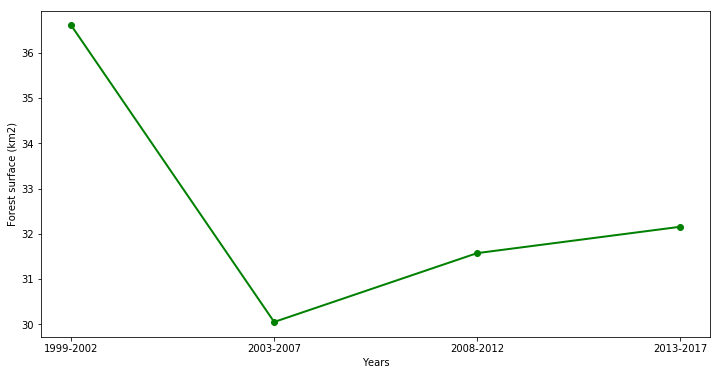

In [28]:
plt.figure(figsize=(12,6))
y=[]
x=[]
xTicks=[]
i=0
for row in year_splitting:
    key = '%d-%d' % (row[0],row[-1])
    x.append(i)
    xTicks.append(key)
    y.append(surface_dict[key])
    i=i+1
plt.xticks(x, xTicks)
plt.xticks(range(4),xTicks)     
plt.plot(x, y, '-o', c='g',lw=2)
plt.xlabel('Years')
plt.ylabel('Forest surface (km2)')
plt.show()

#### SDG INDICATOR

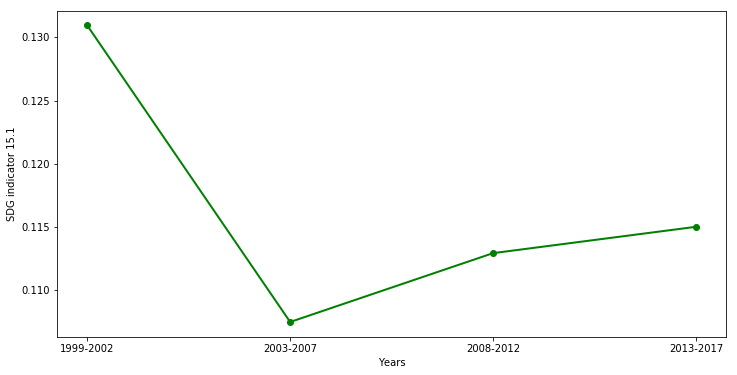

In [29]:
plt.figure(figsize=(12,6))
y=[]
x=[]
xTicks=[]
i=0
for row in year_splitting:
    key = '%d-%d' % (row[0],row[-1])
    x.append(i)
    xTicks.append(key)
    y.append(indicator_dict[key])
    i=i+1
plt.xticks(x, xTicks)
plt.xticks(range(4),xTicks)     
plt.plot(x, y, '-o', c='g',lw=2)
plt.xlabel('Years')
plt.ylabel('SDG indicator 15.1')
plt.show()

### CANTON JURA 

In [12]:
# Canton JURA 
min_lon = 6.82540
max_lon = 7.57596
min_lat = 47.11959
max_lat = 47.54011

In [13]:
## Canton JURA MASK
from osgeo import gdal
dataset = gdal.Open("JURA_MASK.tif")

print("Number of layers ".format(dataset.RasterCount))
print("==== Some info ====")
print("Size of tif file is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
mask_GE = np.array(dataset.GetRasterBand(1).ReadAsArray())
print("The shape of the array is {} ".format(mask_GE.shape))


Number of layers 
==== Some info ====
Size of tif file is 2767 x 1551 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
The shape of the array is (1551, 2767) 


In [20]:
tmp_dc = DataAccessApi()
acquisitions_list_init=tmp_dc.list_acquisition_dates(product=prod, platform=plat, 
        latitude=(min_lat, max_lat), longitude=(min_lon,max_lon),  
        time=(start_date_init,end_date_init))  

[1999, 2000, 2001, 2002]
The forest coverage is  616.6125000000001 km2, for a total of 986580 / 1356630 forest pixels
The total surface  847.8937500000001 km2
[2003, 2004, 2005, 2006, 2007]
The forest coverage is  507.90000000000003 km2, for a total of 812640 / 1356630 forest pixels
The total surface  847.8937500000001 km2
[2008, 2009, 2010, 2011, 2012]
The forest coverage is  605.3256250000001 km2, for a total of 968521 / 1356630 forest pixels
The total surface  847.8937500000001 km2
[2013, 2014, 2015, 2016, 2017]
The forest coverage is  551.453125 km2, for a total of 882325 / 1356630 forest pixels
The total surface  847.8937500000001 km2


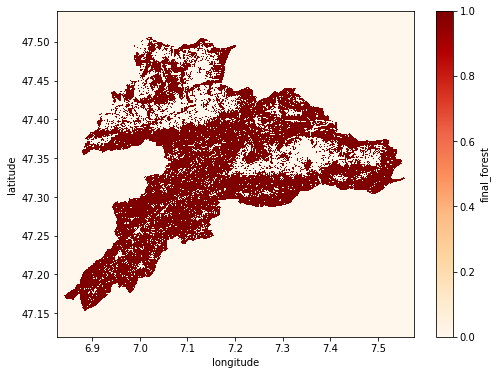

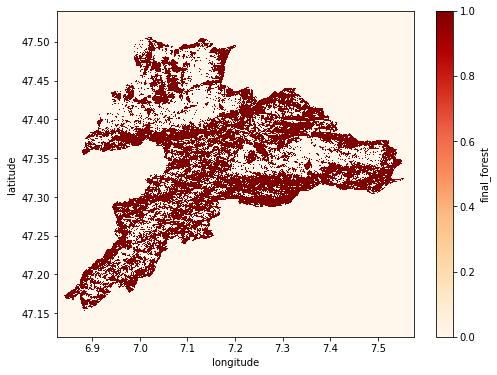

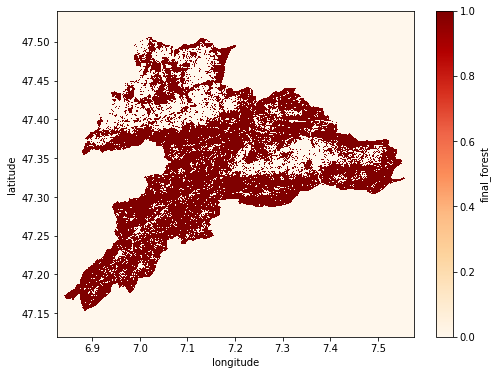

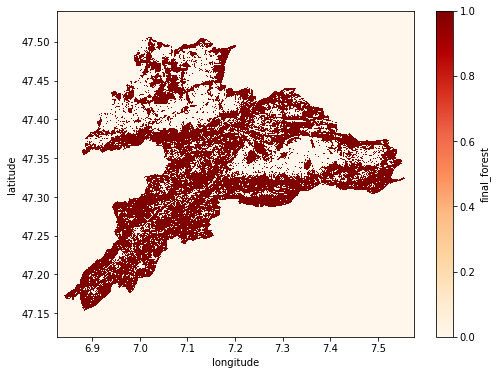

In [17]:
## The LOOP

for row in year_splitting:   
    print(row)
    acquisitions_list_year = []
    for y in row:
        #print(y)
        for t in acquisitions_list_init:
            if (t.year==y): 
                acquisitions_list_year.append(t)
    #print("Acquisition list ",acquisitions_list_year)
    #print("====================")
    dataset_in = dc.load(platform=plat,
                     product=prod,
                     time=(acquisitions_list_year[0],acquisitions_list_year[-1]),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     measurements=['red', 'nir','cf_mask'])
    with np.errstate(invalid='ignore'):
        ndvi = (dataset_in.nir - dataset_in.red) / (dataset_in.nir + dataset_in.red)
    dataset_in['ndvi'] = ndvi.astype(float)

    with np.errstate(invalid='ignore'):
        select_ndvi = dataset_in.ndvi> ndvi_threshold
    dataset_in['forest_mask'] = select_ndvi.astype(int) 
    
    ## filtering for the months and the mask
    dataset_in = dataset_in.sel(time=np.isin(dataset_in['time.month'], sel_months))
    dataset_in = dataset_in.where(mask_GE==1)
    
    unfiltered_forest=dataset_in.forest_mask

    # create dataset for forests (ndvi>xx)
    unfiltered_forest_dataset = unfiltered_forest.astype(np.int16).to_dataset(name = "forest")

    if len(no_cats) > 0:
        no_data = eval(tupple_to_cond(no_cats))
        no_data = no_data.values ## create a mask for the pixels where we don't have clear sky (cf_mask = 2,3,4,255)
        # Apply no_data on MDC
        unfiltered_forest_dataset.forest.values[no_data] = 255 ## N.B. this sets all the values of forest where we 
        # have no data to 255. It is needed for the perform_timeseries_analysis step

    ts = perform_timeseries_analysis(unfiltered_forest_dataset,"forest", no_data = 255)
    
    # select normalized threshold
    with np.errstate(invalid='ignore'):
        forest = ts.normalized_data>ts_percentage
    dataset_in['final_forest'] = forest.astype(int)
    #print(dataset_in.final_forest)
    dataset_in.final_forest.plot(cmap='OrRd',figsize=(8, 6))
    
    tot_pixel_forest_tmp = np.count_nonzero(dataset_in.final_forest)
    #print(baseline_mosaic_tmp)
    #utilities.nan_to_num(forest_baseline_masked, 0)
    
    surface_tmp = tot_pixel_forest_tmp*resolution_km2
    surface_tot = np.count_nonzero(mask_GE==1)*resolution_km2
    print("The forest coverage is ", surface_tmp, "km2, for a total of",tot_pixel_forest_tmp,"/",np.count_nonzero(mask_GE==1),"forest pixels")
    print("The total surface ", surface_tot,"km2")
    print("===================================================")
    surface_dict['%d-%d' % (row[0],row[-1])]=surface_tmp
    indicator_dict['%d-%d' % (row[0],row[-1])]=surface_tmp/surface_tot


### VISUALIZATION  (CANTON JURA)

##### FOREST SURFACE

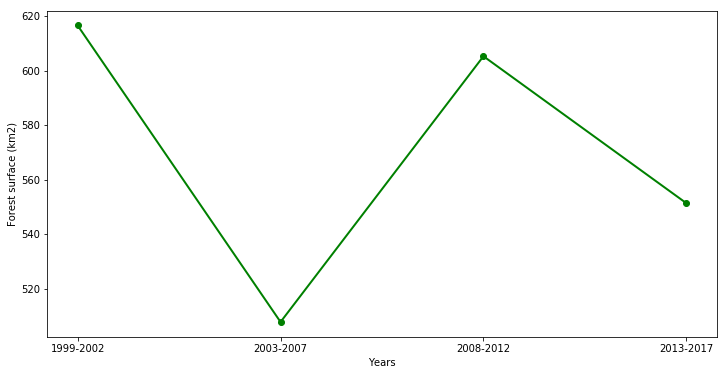

In [18]:
plt.figure(figsize=(12,6))
y=[]
x=[]
xTicks=[]
i=0
for row in year_splitting:
    key = '%d-%d' % (row[0],row[-1])
    x.append(i)
    xTicks.append(key)
    y.append(surface_dict[key])
    i=i+1
plt.xticks(x, xTicks)
plt.xticks(range(4),xTicks)     
plt.plot(x, y, '-o', c='g',lw=2)
plt.xlabel('Years')
plt.ylabel('Forest surface (km2)')
plt.show()

##### SDG INDICATOR

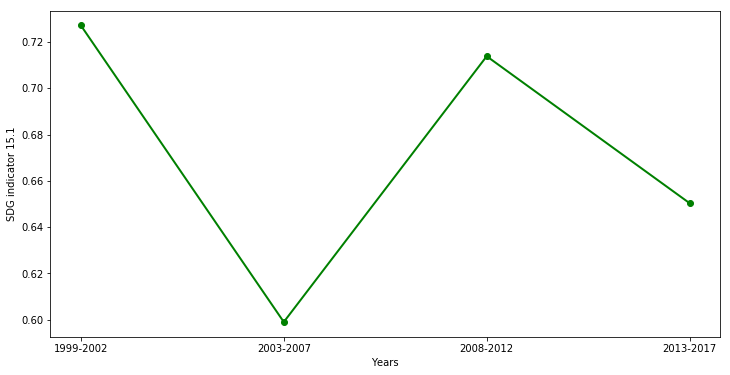

In [19]:
plt.figure(figsize=(12,6))
y=[]
x=[]
xTicks=[]
i=0
for row in year_splitting:
    key = '%d-%d' % (row[0],row[-1])
    x.append(i)
    xTicks.append(key)
    y.append(indicator_dict[key])
    i=i+1
plt.xticks(x, xTicks)
plt.xticks(range(4),xTicks)     
plt.plot(x, y, '-o', c='g',lw=2)
plt.xlabel('Years')
plt.ylabel('SDG indicator 15.1')
plt.show()

# Scratch

In [ ]:
## === MINI DATA CUBE +NDVI
#time_start = datetime.now()
dataset_in = dc.load(platform=plat,
                     product=prod,
                     time=(start, end),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     measurements=['red', 'nir','cf_mask'])
#print(dataset_in)

with np.errstate(invalid='ignore'):
        ndvi = (dataset_in.nir - dataset_in.red) / (dataset_in.nir + dataset_in.red)
dataset_in['ndvi'] = ndvi.astype(float)

with np.errstate(invalid='ignore'):
        select_ndvi = dataset_in.ndvi>0.8
dataset_in['forest_mask'] = select_ndvi.astype(int) 
        
#print(dataset_in)

# NOT USED so far -------------
#mcat = select_ndvi.astype(int)
#mcat_dataset = mcat.astype(np.uint8).to_dataset(name = "mcat")
#print(mcat_dataset)

In [ ]:
## ==== CANTON MASK
from osgeo import gdal
dataset = gdal.Open("GE_MASK_corr.tif")

print("Number of layers ".format(dataset.RasterCount))
print("==== Some info ====")
print("Size of tif file is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
mask_GE = np.array(dataset.GetRasterBand(1).ReadAsArray())
print("The shape of the array is {} ".format(mask_GE.shape))

In [ ]:
## === FILTERING THE MINI DATACUBE for a selection of months and Geneva mask

dataset_in = dataset_in.sel(time=np.isin(dataset_in['time.month'], sel_months))
dataset_in = dataset_in.where(mask_GE==1)

# print(dataset_in)
# dataset_in.isel(time=2).ndvi.plot(cmap='OrRd',figsize=(8, 6))

# creating another mask with 0/1 only
unfiltered_forest=dataset_in.forest_mask
#print(unfiltered_forest)

# create dataset for forests (ndvi>xx)
unfiltered_forest_dataset = unfiltered_forest.astype(np.int16).to_dataset(name = "forest")
print(unfiltered_forest_dataset)
#unfiltered_forest_dataset.isel(time=0).forest.plot(cmap='OrRd',figsize=(8, 6))


In [ ]:
# Define no data categories and apply them on MDC
if len(no_cats) > 0:
    no_data = eval(tupple_to_cond(no_cats))
    no_data = no_data.values ## create a mask for the pixels where we don't have clear sky (cf_mask = 2,3,4,255)
    #print(no_data)
    # Apply no_data on MDC
    unfiltered_forest_dataset.forest.values[no_data] = 255 ## N.B. this sets all the values of forest where we 
    # have no data to 255. It is needed for the perform_timeseries_analysis step

# Few checks..
#print(unfiltered_forest_dataset)
#print(np.sum(unfiltered_forest_dataset.forest.values[no_data]))
#print(np.sum(unfiltered_forest_dataset.forest.values))

### PREVIOUS WAY
# define no data
#no_data = eval(tupple_to_cond(no_cats))
#no_data = dataset_in.cf_mask == 255 ## ORIGINAL ##this is an array of True/False
#print(no_data)
#no_data = no_data.values
#print("========")
#print(no_data)
#unfiltered_forest_dataset.forest.values[no_data]==(255 | 2 | 4) 

In [ ]:
ts = perform_timeseries_analysis(unfiltered_forest_dataset,"forest", no_data = 255)
# Now, we have that the forest can assume the value 0,1,255. The first and the latter must be discarded, so:
##   processed_data_sum = data.where(data != no_data).sum('time')  --> sum over time only those pixels which are clear
##   clean_data = data.where(data != no_data).notnull()  --> this checks only the non-null values, meaning the actual forest pixels
print(ts)
#ts.total_data.plot(cmap='OrRd',figsize=(8, 6))
#ts.normalized_data.plot(cmap='OrRd',figsize=(8, 6)) # actually this is the percentage [0-100%]
#ts.total_clean.plot(cmap='OrRd',figsize=(8, 6))     # actually this is the percentage [0-100%]

In [ ]:
# select normalized threshold
with np.errstate(invalid='ignore'):
        forest = ts.normalized_data>0.3
dataset_in['final_forest'] = forest.astype(int)
print(dataset_in.final_forest)
dataset_in.final_forest.plot(cmap='OrRd',figsize=(8, 6))

In [ ]:
#resolution_km2 = 30*30/1000000
resolution_km2 = 25*25/1000000

# Dictionary for plotting later
surf_dict={}

for y in year_splitting: 
    print(y)
     
    tot_pixel_forest_tmp = np.count_nonzero(dataset_in.final_forest)
    #print(baseline_mosaic_tmp)
    #utilities.nan_to_num(forest_baseline_masked, 0)
    
    surface_tmp = tot_pixel_forest_tmp*resolution_km2
    surf_dict[str(y)]=surface_tmp
    print("The forest coverage for the year", y, " in canton GE is", surface_tmp, "km2, for a total of",tot_pixel_forest_tmp,"/",np.count_nonzero(mask_GE==1),"forest pixels")
    print("total surface ",np.count_nonzero(mask_GE==1)*resolution_km2,"km2")


In [ ]:
# Save results as netcdf
nc_name = 'geneve07.nc'
ts.to_netcdf(nc_name)
print('Results saved as %s' % (nc_name))

In [ ]:
# pretty_plot function

time_start = datetime.now()

def pretty_plot(data, leg, bar_title):
    # To be adapted
    max_pixels = 2000
    max_size = 16
    # Estimate aspect
    pxx = ts.dims['longitude']
    pxy = ts.dims['latitude']
    ratio = int(max(pxy,pxx)/max_pixels)
    
    orient = 'horizontal'
    cb_pad = 0.03
    if pxx < pxy:
        orient = 'vertical'
        cb_pad = 0.01
    
    fig, ax = plt.subplots(figsize=(max_size,max_size))
    
    if ratio > 1:
        to = data[::ratio,::ratio]
        cax = ax.imshow(to, interpolation='nearest', cmap=leg)
        plt.xticks([0,to.shape[1]], [round(float(np.min(to.longitude)),1),round(float(np.max(to.longitude)),1)])
        plt.yticks([to.shape[0],0], [round(float(np.min(to.latitude)),1),round(float(np.max(to.latitude)),1)])
    else:
        cax = ax.imshow(data, interpolation='nearest', cmap=leg)
        plt.xticks([0,data.shape[1]], [round(float(np.min(data.longitude)),1),round(float(np.max(data.longitude)),1)])
        plt.yticks([data.shape[0],0], [round(float(np.min(data.latitude)),1),round(float(np.max(data.latitude)),1)])

    cbar = fig.colorbar(cax, orientation=orient, aspect=100, pad=cb_pad)
    cbar.set_label(label='%s - %s' % (title, bar_title),weight='bold')
    plt.xlabel('Longitude', labelpad=-10)
    plt.ylabel('Latitude', labelpad=-25)

    plt.draw()

In [ ]:
pretty_plot(ts.total_data, colors.LinearSegmentedColormap.from_list('beige_to_green', ['beige','green'], N=256), 'Total data')
pretty_plot(ts.normalized_data, colors.LinearSegmentedColormap.from_list('beige_to_green', ['white','white','beige','green'], N=256), 'Normalized data')
#pretty_plot(ts.normalized_data, colors.LinearSegmentedColormap.from_list('beige_to_green', ['white','white','beige','green'], N=256), 'Normalized data')

In [ ]:
pretty_plot(ts.total_clean, 'RdYlGn', 'Total clean')

In [ ]:
print(ts)

### Visualizing the trend on a scatter plot

In [ ]:
plt.figure(figsize=(12,6))
y=[]
for yr in year_splitting:
    y.append(surf_dict[str(yr)])
plt.plot(year_splitting, y, '-o', c='g',lw=2)
plt.xlabel('Year')
plt.ylabel('Forest surface (km2) - canton GE')
plt.show()

### Animation

In [ ]:
import imageio
from glob import glob
from IPython.display import Image, display

images = []
for s in sorted(glob('forest_b_*.png')):
#for filename in filenames:
    images.append(imageio.imread(s))
imageio.mimsave('forest_animation.gif', images)
Image(url='forest_animation.gif')  